<a href="https://colab.research.google.com/github/DomenicoArmillotta/ImageClassification-OCT/blob/main/pyTorch_implementation/PyTorch_OCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from __future__ import print_function, division
from tqdm import tqdm	

import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from google.colab import drive

import os
import copy

plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")


Using CUDA


In [2]:
# setup directory used in the project for training and test phase
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/dataset/OCT'
train_dir = '/content/drive/MyDrive/dataset/OCT/train'
test_dir = '/content/drive/MyDrive/dataset/OCT/test'
val_dir = '/content/drive/MyDrive/dataset/OCT/val'

Mounted at /content/drive


questi procedimenti lo fa anche il sito ufficiale di pyTorch

1. data_transform
2. image_dataset
3. dataloaders

In [4]:
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

# VGG-16 Takes 224x224 images as input, so we resize all of them
# viene creato un dizionario con 3 oggetti di tipo transofrm.compose che sono di pythorch
#fatto una piccla augmentation solo al training set
data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set --> aumenta la generalizzazzione (conviene farlo in sto dataset??)
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally. 
        transforms.RandomResizedCrop(224), #fissato una size di 224 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224), #-> per resnet va bene 224
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

#applico le trasformazioni alle immagini del dataset salvato nelle directory
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

#batch size mi sembra piccolo , ma il tutorial di py lo mette a 4 , quindi proviamo con 8 e poi si vede --> aggiornato a 64
# num worker sono i thread paralleli che si possono usare --> colab consiglia di mettere a 2
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=64,
        shuffle=True, num_workers=2
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 83484 images under train
Loaded 32 images under val
Loaded 968 images under test
Classes: 
['CNV', 'DME', 'DRUSEN', 'NORMAL']


facciamo una visualizzazzione del train

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8ad678c3a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.8/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


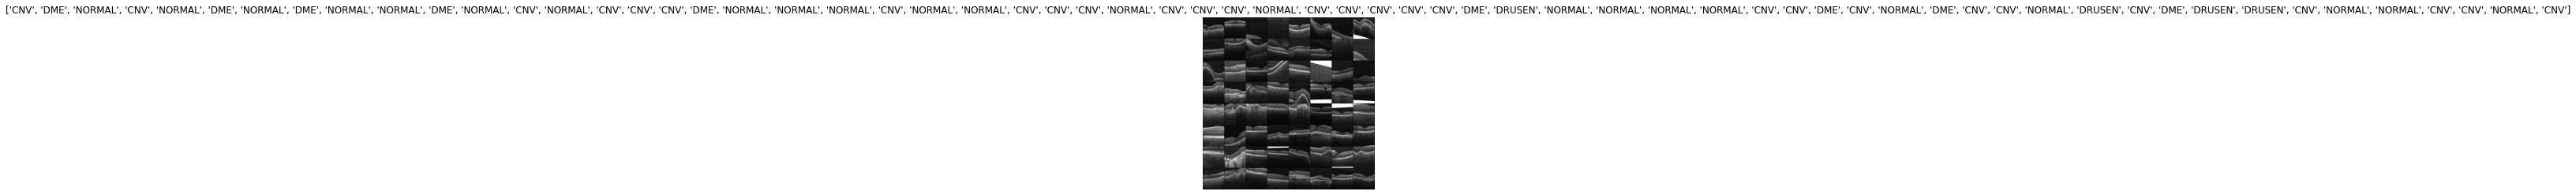

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) #to ensure that the plot is displayed.

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs) # create a grid of images from the batch
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

# **Resnet18 - prova1**

questo è la parte di training 
moificato il codice in modo da avere una progress bar e il numero massimo di step_per_epoch --> puo essere settato a None o ad un numero

aggiunto anche l'early stopping con la pazienza = 5

In [5]:
def train_model_early_stopping(model, criterion, optimizer, scheduler, num_epochs=10, max_steps_per_epoch=200, patience=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    no_improvement_count = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Create a progress bar for this phase
            if max_steps_per_epoch is not None:
                progress_bar = tqdm(dataloaders[phase] , total=max_steps_per_epoch)
            else : 
                progress_bar = tqdm(dataloaders[phase] , total=len(dataloaders[phase]))

            # Iterate over data.
            for i, (inputs, labels) in enumerate(progress_bar):
                if max_steps_per_epoch is not None and i >= max_steps_per_epoch:
                    break

                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                #statics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


                progress_bar.set_postfix({'Loss': loss.item(), 'Acc': torch.sum(preds == labels.data).item() / len(labels)})
                

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # early stopping logic  --> se l'accuracy non aumenta per il numero di epoche pari alla pazienza , interrompe l'allenamento e tiene il migliore
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    no_improvement_count = 0
                else:
                    no_improvement_count += 1

                    if no_improvement_count >= patience:
                        print(f'Early stopping after {epoch+1} epochs.')
                        print(f'Best val Acc: {best_acc:4f}')
                        model.load_state_dict(best_model_wts)
                        return model

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model


funzione per visualizzare qualche immagine e la predizione fatta dal modello

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):

            if use_gpu:
              inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
              inputs, labels = Variable(inputs), Variable(labels)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### **FineTuning**

carichiamo il modello pre trainato

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

alleniamo il modello

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

In [ ]:
visualize_model(model_ft)


### **Feature Reuse** --> potrebbe essere cio che vogliamo perche l immagini di allenamento sono molto diverse dalle nostre

In [7]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 4) #fully connected layer of a pre-trained convolutional neural network (CNN) with a new layer that outputs 4 classes.

# model_conv = model_conv.to(device)
if use_gpu:
    model_conv.cuda() #.cuda() will move everything to the GPU side

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model_conv = train_model_early_stopping(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler)

torch.save(model_conv.state_dict(), 'ResNet18_feature-OCT_Retina.pt')

Epoch 0/9
----------


  9%|▉         | 18/200 [08:00<1:08:58, 22.74s/it, Loss=1.06, Acc=0.594]

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

# **Stop Execution**

In [ ]:
from google.colab import runtime
runtime.unassign()